In [1]:
import requests
import pandas as pd
import numpy as np
import warnings
import time
import os
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
from skimage.color import rgb2gray
from sklearn.feature_selection import VarianceThreshold

In [2]:
sns.set_theme(style='white', palette='pastel', font_scale=1.1)

# Fetching Data

In [4]:
hnm_file_format = 'data/HnM_{}.parquet'
hnm_img_file = 'images/HnM_{}{}'
cna_file_format = 'data/CnA_{}.parquet'
cna_img_file = 'images/CnA_{}{}'

In [ ]:
hnm_cats = pd.read_parquet(hnm_file_format.format('Categories'))
hnm_filters = pd.read_parquet(hnm_file_format.format('Filters'))
hnm_items = pd.read_parquet(hnm_file_format.format('Items'))
hnm_attributes = pd.read_parquet(hnm_file_format.format('FilterAttributes'))

In [ ]:
cna_cats = pd.read_parquet(cna_file_format.format('Categories'))
cna_filters = pd.read_parquet(cna_file_format.format('Filters'))
cna_items = pd.read_parquet(cna_file_format.format('Items'))
cna_attributes = pd.read_parquet(cna_file_format.format('FilterAttributes'))

# Combine parent categories

In [ ]:
hnm_cats[hnm_cats['Parent_Category'].isna()]['Category'].unique()

In [ ]:
cna_cats[cna_cats['Parent_Category'].isna()]['Category'].unique()

In [ ]:
hnm_items['Code'].nunique()

In [ ]:
cna_items['Code'].nunique()

## Might lead to incorrect results - continue and work only with HnM for now

In [5]:
cats = pd.read_parquet(hnm_file_format.format('Categories'))
filters = pd.read_parquet(hnm_file_format.format('Filters'))
items = pd.read_parquet(hnm_file_format.format('Items'))
attributes = pd.read_parquet(hnm_file_format.format('FilterAttributes'))

In [6]:
cats.head()

,Category,URL,Parent_Category,Top_Category,Skip
0,Shirts & Tops,/de_de/damen/produkte/tops.html,NaN,Women,False
1,Basics,/de_de/damen/produkte/basics.html,NaN,Women,False
2,Hemden & Blusen,/de_de/damen/produkte/hemden-blusen.html,NaN,Women,False
3,Cardigans & Pullover,/de_de/damen/produkte/cardigans-pullover.html,NaN,Women,False
4,Strickwaren,/de_de/damen/produkte/strickwaren.html,NaN,Women,False


In [7]:
# check items per parent category
# join parent categories into items
items.head()

,Code,Name,URL,Img_URL,Img_Ext,Category
0,1071498001,Cut-out-Shirt,/de_de/productpage.1071498001.html,//lp2.hm.com/hmgoepprod?set=source[/a2/90/a290...,.jpg,29.0
1,1069183001,Kurzes Shirt mit Cut-out,/de_de/productpage.1069183001.html,//lp2.hm.com/hmgoepprod?set=source[/12/09/1209...,.jpg,29.0
2,0985757001,Kurzshirt mit Cut-out,/de_de/productpage.0985757001.html,//lp2.hm.com/hmgoepprod?set=source[/68/a3/68a3...,.jpg,29.0
3,0985757002,Kurzshirt mit Cut-out,/de_de/productpage.0985757002.html,//lp2.hm.com/hmgoepprod?set=source[/10/22/1022...,.jpg,29.0
4,1069183002,Kurzes Shirt mit Cut-out,/de_de/productpage.1069183002.html,//lp2.hm.com/hmgoepprod?set=source[/d1/3a/d13a...,.jpg,29.0


### Total categories in each main category and images in each main category

In [ ]:
cats[(cats['Parent_Category'].isna()) & (cats['Skip'] == False)].groupby(['Top_Category'])['Category'].count().reset_index()

Adding Parent Category Details and Top Category Details

In [8]:
# adding top category name and parent category id
items = items.merge(
    cats[['Category', 'Parent_Category', 'Top_Category']], 
    how='left', 
    left_on='Category', 
    right_index=True
).drop(
    columns='Category_y'
).rename(
    columns={
        'Category_x': 'Category'
    }
)

In [9]:
items.head()

,Code,Name,URL,Img_URL,Img_Ext,Category,Parent_Category,Top_Category
0,1071498001,Cut-out-Shirt,/de_de/productpage.1071498001.html,//lp2.hm.com/hmgoepprod?set=source[/a2/90/a290...,.jpg,29.0,0.0,Women
1,1069183001,Kurzes Shirt mit Cut-out,/de_de/productpage.1069183001.html,//lp2.hm.com/hmgoepprod?set=source[/12/09/1209...,.jpg,29.0,0.0,Women
2,0985757001,Kurzshirt mit Cut-out,/de_de/productpage.0985757001.html,//lp2.hm.com/hmgoepprod?set=source[/68/a3/68a3...,.jpg,29.0,0.0,Women
3,0985757002,Kurzshirt mit Cut-out,/de_de/productpage.0985757002.html,//lp2.hm.com/hmgoepprod?set=source[/10/22/1022...,.jpg,29.0,0.0,Women
4,1069183002,Kurzes Shirt mit Cut-out,/de_de/productpage.1069183002.html,//lp2.hm.com/hmgoepprod?set=source[/d1/3a/d13a...,.jpg,29.0,0.0,Women


In [10]:
# adding name of parent category also
items = items.merge(
    cats[['Category', 'Parent_Category']], 
    left_on='Parent_Category', 
    right_index=True, 
    how='left'
).rename(
    columns={
        'Category_x': 'Category',
        'Category_y': 'Parent_Category_Name',
        'Parent_Category_x': 'Parent_Category'
}
).drop(
    columns='Parent_Category_y'
)

In [11]:
items['Code'].nunique()

16473

In [12]:
items.groupby('Top_Category')['Parent_Category_Name'].nunique().reset_index()

,Top_Category,Parent_Category_Name
0,Baby,4
1,Kids,4
2,Men,16
3,Women,20


Some categories do not have a product: Should be explored later!

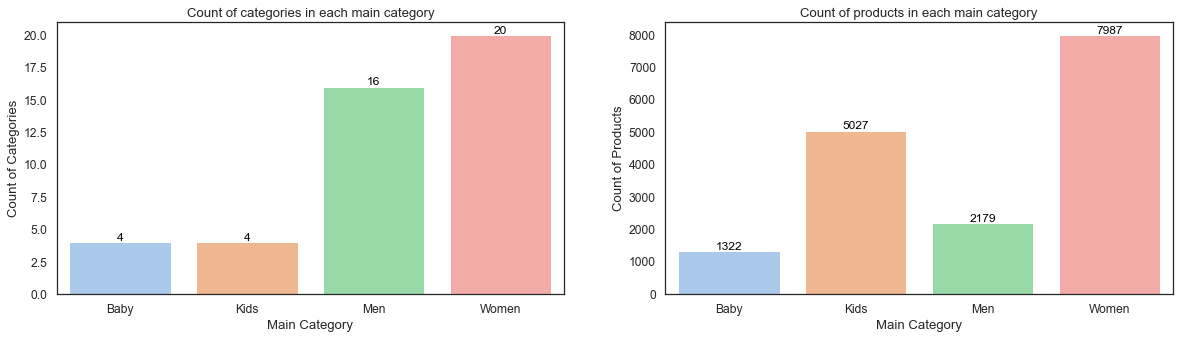

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharex=True)

sns.barplot(
    data=items.groupby('Top_Category')['Parent_Category_Name'].nunique().reset_index(),
    x='Top_Category',
    y='Parent_Category_Name',
    ax=axes[0]
)
axes[0].set(
    xlabel = 'Main Category',
    ylabel = 'Count of Categories',
    title = 'Count of categories in each main category'
)

for p in axes[0].patches:
    axes[0].text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, color='black', ha='center', va='bottom')

    
sns.barplot(
    data=items.groupby('Top_Category')['Code'].nunique().reset_index(),
    x='Top_Category',
    y='Code'
)    
axes[1].set(
    xlabel = 'Main Category',
    ylabel = 'Count of Products',
    title = 'Count of products in each main category'
)

for p in axes[1].patches:
    axes[1].text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, color='black', ha='center', va='bottom')


plt.show()

In [14]:
overlaps = items.groupby(['Top_Category', 'Code'])['Category'].nunique().reset_index().groupby(['Top_Category', 'Category'])['Code'].count().reset_index().rename(columns={'Category': 'Category_Cnt', 'Code': 'Nr_Of_Products'})

In [15]:
overlaps

,Top_Category,Category_Cnt,Nr_Of_Products
0,Baby,1,1056
1,Baby,2,33
2,Baby,3,220
3,Baby,4,4
4,Baby,5,9
5,Kids,1,4507
6,Kids,2,201
7,Kids,3,308
8,Kids,4,10
9,Kids,5,1


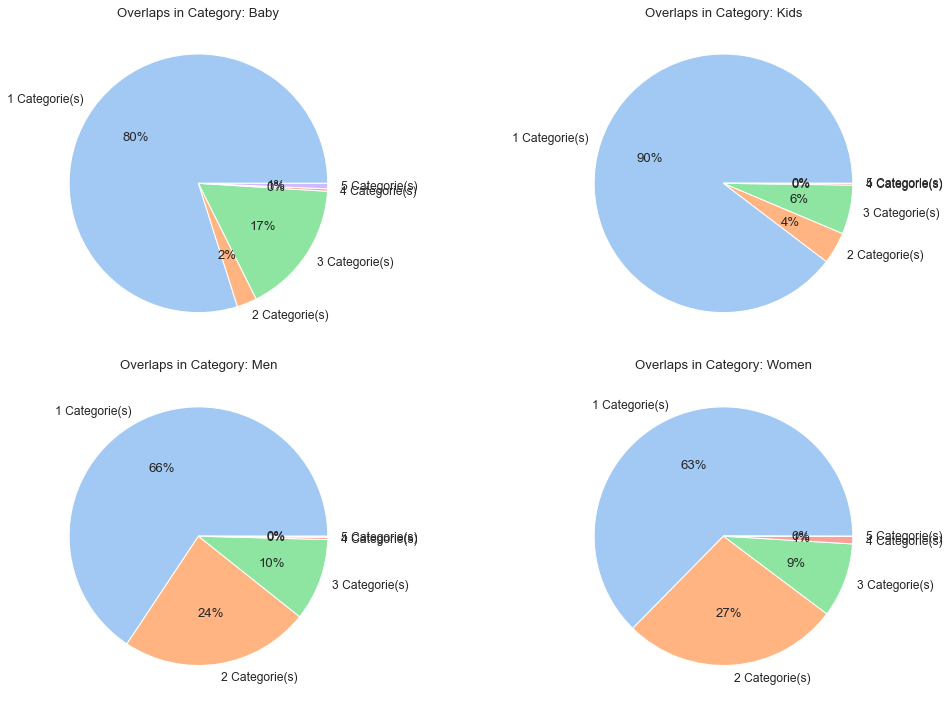

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

colors = sns.color_palette('pastel')[0:overlaps['Category_Cnt'].max()]

#create pie chart
for i, c in enumerate(overlaps['Top_Category'].unique()):
    data = overlaps[overlaps['Top_Category'] == c]
    axes[i].set_title(f'Overlaps in Category: {c}')
    axes[i].pie(data['Nr_Of_Products'], labels = list(map(lambda x: f"{x} Categorie(s)", list(data['Category_Cnt']))), colors = colors, autopct='%.0f%%')

plt.tight_layout()
plt.show()

In [17]:
items.head()

,Code,Name,URL,Img_URL,Img_Ext,Category,Parent_Category,Top_Category,Parent_Category_Name
0,1071498001,Cut-out-Shirt,/de_de/productpage.1071498001.html,//lp2.hm.com/hmgoepprod?set=source[/a2/90/a290...,.jpg,29.0,0.0,Women,Shirts & Tops
1,1069183001,Kurzes Shirt mit Cut-out,/de_de/productpage.1069183001.html,//lp2.hm.com/hmgoepprod?set=source[/12/09/1209...,.jpg,29.0,0.0,Women,Shirts & Tops
2,0985757001,Kurzshirt mit Cut-out,/de_de/productpage.0985757001.html,//lp2.hm.com/hmgoepprod?set=source[/68/a3/68a3...,.jpg,29.0,0.0,Women,Shirts & Tops
3,0985757002,Kurzshirt mit Cut-out,/de_de/productpage.0985757002.html,//lp2.hm.com/hmgoepprod?set=source[/10/22/1022...,.jpg,29.0,0.0,Women,Shirts & Tops
4,1069183002,Kurzes Shirt mit Cut-out,/de_de/productpage.1069183002.html,//lp2.hm.com/hmgoepprod?set=source[/d1/3a/d13a...,.jpg,29.0,0.0,Women,Shirts & Tops


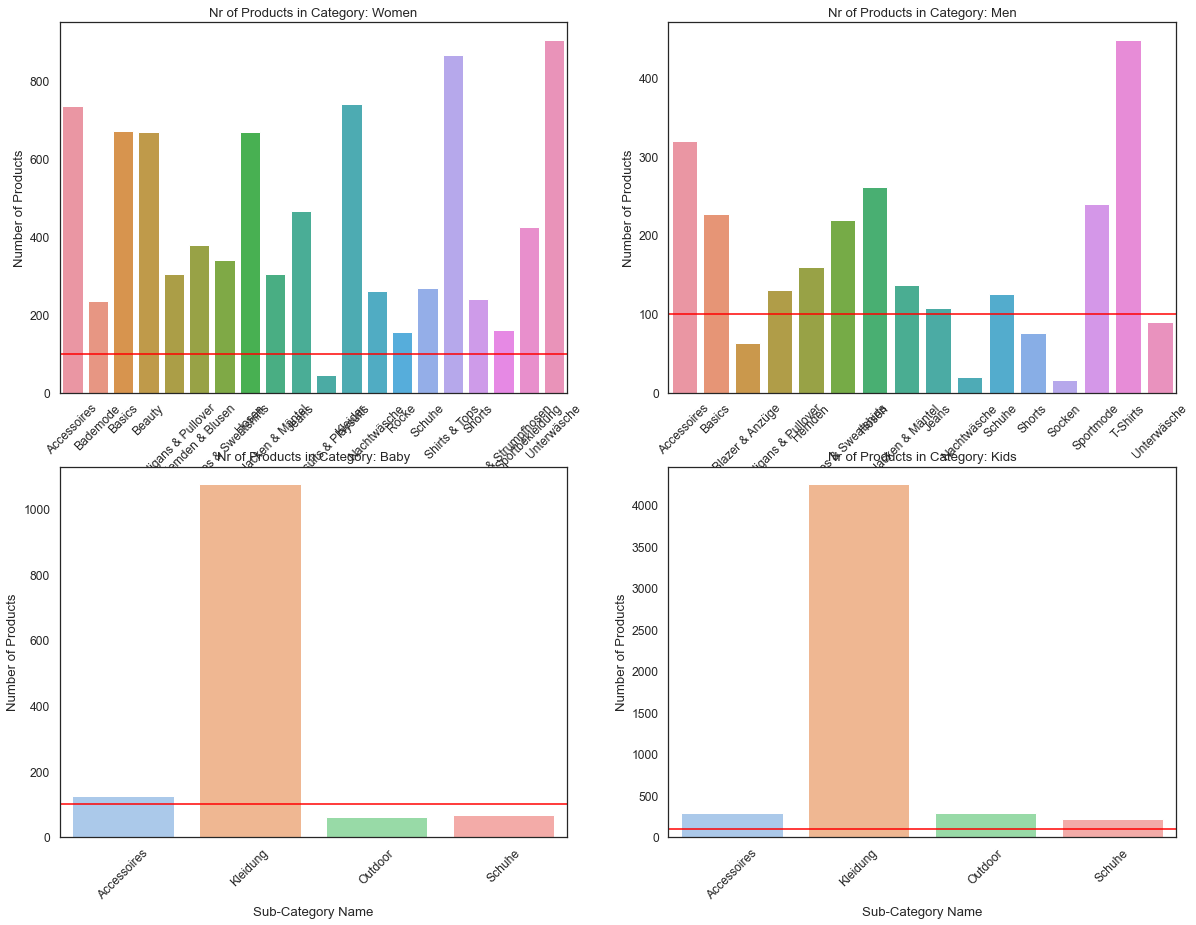

In [18]:
limit = 100

fig, axes = plt.subplots(2, 2, figsize=(20, 15))
axes = axes.ravel()

for i, c in enumerate(items['Top_Category'].unique()):
    data = items[items['Top_Category'] == c].groupby('Parent_Category_Name')['Code'].nunique().reset_index().rename(columns={'Code': 'Nr_Of_Products'})
    sns.barplot(
        data = data,
        x = 'Parent_Category_Name',
        y = 'Nr_Of_Products',
        ax=axes[i]
    )
    axes[i].set(
        title = f"Nr of Products in Category: {c}",
        xlabel = "Sub-Category Name",
        ylabel = 'Number of Products',
    )
    axes[i].tick_params(axis='x', labelrotation = 45)
    axes[i].axhline(y=limit, color='red')

plt.show()

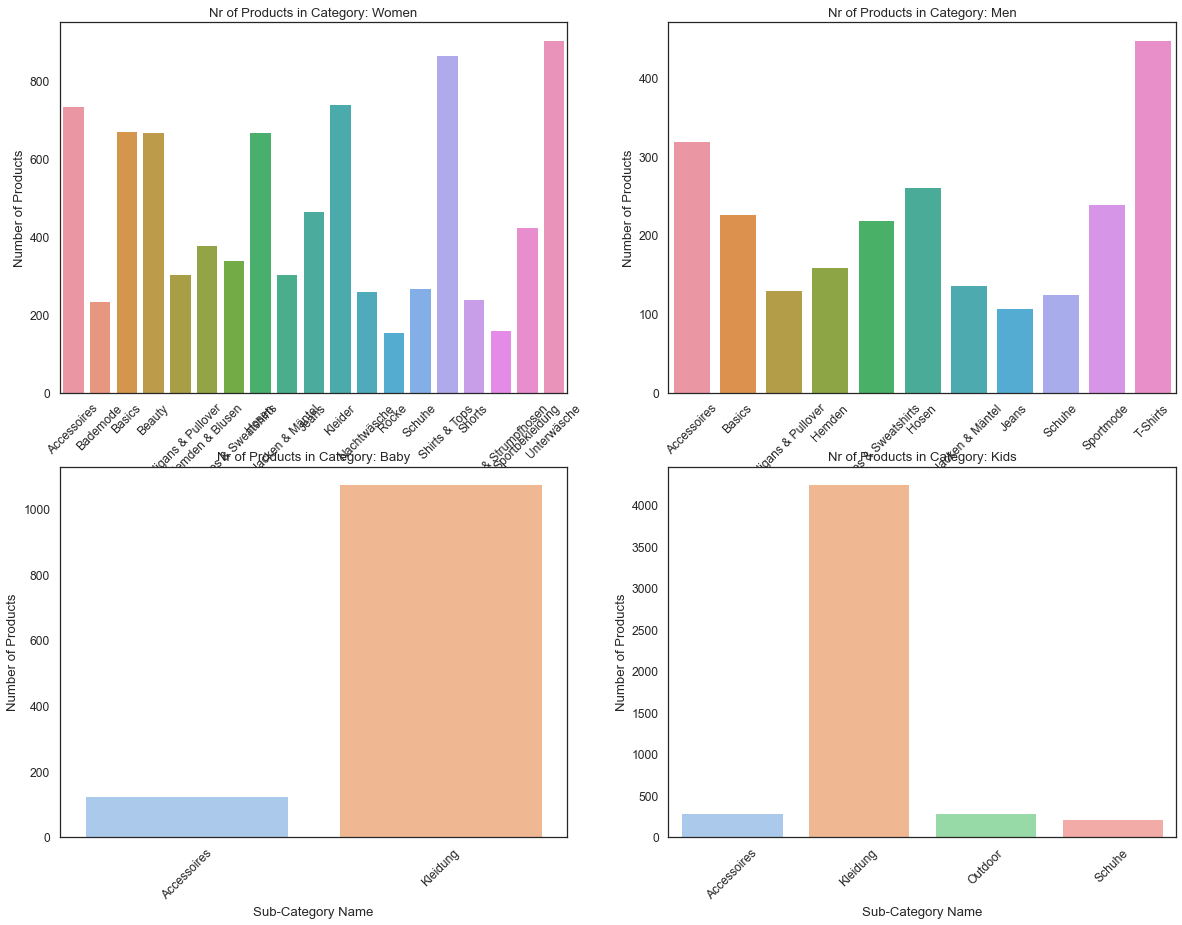

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
axes = axes.ravel()

for i, c in enumerate(items['Top_Category'].unique()):
    data = items[items['Top_Category'] == c].groupby('Parent_Category_Name')['Code'].nunique().reset_index().rename(columns={'Code': 'Nr_Of_Products'})
    sns.barplot(
        data = data[data['Nr_Of_Products'] > limit],
        x = 'Parent_Category_Name',
        y = 'Nr_Of_Products',
        ax=axes[i]
    )
    axes[i].set(
        title = f"Nr of Products in Category: {c}",
        xlabel = "Sub-Category Name",
        ylabel = 'Number of Products',
    )
    axes[i].tick_params(axis='x', labelrotation = 45)

plt.show()

In [20]:
d = items.groupby(['Top_Category', 'Parent_Category', 'Parent_Category_Name'])['Code'].nunique().reset_index().rename(columns={'Code': 'Nr_Of_Products'})
print(f"Categories to consider = {d[d['Nr_Of_Products'] > limit].shape[0]}")

Categories to consider = 36


In [63]:
print(d[d['Nr_Of_Products'] > limit]['Parent_Category_Name'].unique())

['Kleidung' 'Accessoires' 'Outdoor' 'Schuhe' 'Jacken & Mäntel'
 'Hoodies & Sweatshirts' 'Cardigans & Pullover' 'Hemden' 'T-Shirts'
 'Hosen' 'Jeans' 'Basics' 'Sportmode' 'Shirts & Tops' 'Hemden & Blusen'
 'Shorts' 'Röcke' 'Kleider' 'Bademode' 'Unterwäsche' 'Nachtwäsche'
 'Socken & Strumpfhosen' 'Sportbekleidung' 'Beauty']


In [21]:
final_cats = d[d['Nr_Of_Products'] > 100]['Parent_Category'].values

In [22]:
items['Final_Cat'] = items.apply(lambda row: True if row['Parent_Category'] in final_cats else False, axis=1)

In [23]:
items.head()

,Code,Name,URL,Img_URL,Img_Ext,Category,Parent_Category,Top_Category,Parent_Category_Name,Final_Cat
0,1071498001,Cut-out-Shirt,/de_de/productpage.1071498001.html,//lp2.hm.com/hmgoepprod?set=source[/a2/90/a290...,.jpg,29.0,0.0,Women,Shirts & Tops,True
1,1069183001,Kurzes Shirt mit Cut-out,/de_de/productpage.1069183001.html,//lp2.hm.com/hmgoepprod?set=source[/12/09/1209...,.jpg,29.0,0.0,Women,Shirts & Tops,True
2,0985757001,Kurzshirt mit Cut-out,/de_de/productpage.0985757001.html,//lp2.hm.com/hmgoepprod?set=source[/68/a3/68a3...,.jpg,29.0,0.0,Women,Shirts & Tops,True
3,0985757002,Kurzshirt mit Cut-out,/de_de/productpage.0985757002.html,//lp2.hm.com/hmgoepprod?set=source[/10/22/1022...,.jpg,29.0,0.0,Women,Shirts & Tops,True
4,1069183002,Kurzes Shirt mit Cut-out,/de_de/productpage.1069183002.html,//lp2.hm.com/hmgoepprod?set=source[/d1/3a/d13a...,.jpg,29.0,0.0,Women,Shirts & Tops,True


In [ ]:
# items = items.astype({'Category':object})

In [24]:
items = items.merge(cats[['Category']], left_on='Category', right_index=True, how='left')

In [25]:
items.rename(columns={'Category_y': 'Category_Name'}, inplace=True)

In [26]:
items.head()

,Code,Name,URL,Img_URL,Img_Ext,Category_x,Parent_Category,Top_Category,Parent_Category_Name,Final_Cat,Category_Name
0,1071498001,Cut-out-Shirt,/de_de/productpage.1071498001.html,//lp2.hm.com/hmgoepprod?set=source[/a2/90/a290...,.jpg,29.0,0.0,Women,Shirts & Tops,True,Cut-Out-Tops
1,1069183001,Kurzes Shirt mit Cut-out,/de_de/productpage.1069183001.html,//lp2.hm.com/hmgoepprod?set=source[/12/09/1209...,.jpg,29.0,0.0,Women,Shirts & Tops,True,Cut-Out-Tops
2,0985757001,Kurzshirt mit Cut-out,/de_de/productpage.0985757001.html,//lp2.hm.com/hmgoepprod?set=source[/68/a3/68a3...,.jpg,29.0,0.0,Women,Shirts & Tops,True,Cut-Out-Tops
3,0985757002,Kurzshirt mit Cut-out,/de_de/productpage.0985757002.html,//lp2.hm.com/hmgoepprod?set=source[/10/22/1022...,.jpg,29.0,0.0,Women,Shirts & Tops,True,Cut-Out-Tops
4,1069183002,Kurzes Shirt mit Cut-out,/de_de/productpage.1069183002.html,//lp2.hm.com/hmgoepprod?set=source[/d1/3a/d13a...,.jpg,29.0,0.0,Women,Shirts & Tops,True,Cut-Out-Tops


In [27]:
items.groupby(['Top_Category', 'Parent_Category'])['Code'].count()

Top_Category  Parent_Category
Baby          339.0              1568
              340.0                71
              341.0               136
              342.0                68
Kids          367.0              5031
              368.0               323
              369.0               309
              370.0               215
Men           225.0               245
              226.0               220
              227.0               146
              229.0               199
              230.0               593
              231.0               278
              232.0               120
              233.0                90
              234.0                20
              235.0                16
              237.0               137
              238.0               131
              239.0               337
              240.0               227
              241.0               315
              243.0                98
Women         0.0                1414
              1.0   

In [28]:
# items in more than 1 category
items.groupby('Code')['Parent_Category'].nunique().value_counts()

1    15100
2     1353
3       20
Name: Parent_Category, dtype: int64

In [29]:
# items in more than 1 top category
items.groupby('Code')['Top_Category'].nunique().value_counts()

1    16431
2       42
Name: Top_Category, dtype: int64

In [30]:
# exploring these items
c = (items.groupby('Code')['Top_Category'].nunique())
c = c[c > 1]
items[items['Code'].isin(c.index)].sort_values('Code').head(100)

,Code,Name,URL,Img_URL,Img_Ext,Category_x,Parent_Category,Top_Category,Parent_Category_Name,Final_Cat,Category_Name
14933,0886667005,Trinkflasche aus Edelstahl,/de_de/productpage.0886667005.html,//lp2.hm.com/hmgoepprod?set=source[/f3/d8/f3d8...,.jpg,330.0,241.0,Men,Sportmode,True,Accessoires
14285,0886667005,Trinkflasche aus Edelstahl,/de_de/productpage.0886667005.html,//lp2.hm.com/hmgoepprod?set=source[/f3/d8/f3d8...,.jpg,316.0,239.0,Men,Accessoires,True,Sportzubehör
10642,0886667005,Trinkflasche aus Edelstahl,/de_de/productpage.0886667005.html,//lp2.hm.com/hmgoepprod?set=source[/f3/d8/f3d8...,.jpg,169.0,20.0,Women,Sportbekleidung,True,Accessoires
16599,0955549005,Badehandtuch mit Kapuze,/de_de/productpage.0955549005.html,//lp2.hm.com/hmgoepprod?set=source[/be/aa/beaa...,.jpg,353.0,339.0,Baby,Kleidung,True,Bademode
21867,0955549005,Badehandtuch mit Kapuze,/de_de/productpage.0955549005.html,//lp2.hm.com/hmgoepprod?set=source[/be/aa/beaa...,.jpg,385.0,367.0,Kids,Kleidung,True,Bademode
...,...,...,...,...,...,...,...,...,...,...,...
14147,1095330004,Padded Pak'r,/de_de/productpage.1095330004.html,//lp2.hm.com/hmgoepprod?set=source[/36/a6/36a6...,.jpg,313.0,239.0,Men,Accessoires,True,Taschen
7501,1095330006,Padded Pak'r,/de_de/productpage.1095330006.html,//lp2.hm.com/hmgoepprod?set=source[/ea/07/ea07...,.jpg,135.0,14.0,Women,Accessoires,True,Taschen
14146,1095330006,Padded Pak'r,/de_de/productpage.1095330006.html,//lp2.hm.com/hmgoepprod?set=source[/ea/07/ea07...,.jpg,313.0,239.0,Men,Accessoires,True,Taschen
14121,1095332001,The One,/de_de/productpage.1095332001.html,//lp2.hm.com/hmgoepprod?set=source[/27/e4/27e4...,.jpg,313.0,239.0,Men,Accessoires,True,Taschen


In [31]:
items[items['Code'].isin(c.index)].sort_values('Code').groupby(['Top_Category', 'Category_Name'])['Code'].count()

Top_Category  Category_Name          
Baby          Bademode                    2
              Mützen                      1
              Pullover & Strickjacken     1
              Socken                      6
Kids          Bademode                    2
              Mützen, Hüte & Caps         1
              Pullover & Sweatshirts      1
              Socken & Strumpfhosen       6
Men           Accessoires                 6
              Hüte & Caps                 6
              Sandalen & Espadrilles      1
              Sonnenbrillen               3
              Sportzubehör                6
              Taschen                    16
Women         Accessoires                 6
              Hüte & Mützen               6
              Sandalen & Espadrilles      1
              Sonnenbrillen               3
              Taschen                    16
              Yoga                        1
Name: Code, dtype: int64

In [ ]:
# seems to be ok... not a problem - mostly in generic categories

Taking only the final items now

In [32]:
items_final = items[items['Final_Cat']]

Some EDA on filters

In [33]:
attributes.shape

(141147, 2)

In [34]:
# keeping values only for items of interest
items_attribs = attributes[attributes['Code'].isin(items_final['Code'])]

In [35]:
items_attribs.shape

(130288, 2)

In [36]:
# joining filter names and values into attribs
items_attribs = items_attribs.merge(filters, how='left', left_on='Filter_ID', right_index=True)

In [37]:
# joining top category and parent category name into attribs df
items_attribs = items_attribs.merge(items_final[['Code', 'Top_Category', 'Parent_Category_Name']], how='left', on='Code')

In [38]:
# seeing unique filter groups
filters_per_cat = items_attribs.groupby(['Parent_Category'])['Filter_Name'].nunique().reset_index()

In [39]:
# looking at unique filters per code
unique_filters = items_attribs.groupby(['Code', 'Top_Category', 'Parent_Category', 'Parent_Category_Name'])['Filter_Name'].nunique().reset_index()

In [40]:
# join back expected filters_per_cat
unique_filters = unique_filters.merge(filters_per_cat, how='left', on='Parent_Category').rename(columns={'Filter_Name_x': 'Nr_Of_Filters', 'Filter_Name_y': 'Total_Filters'})

In [41]:
unique_filters['Missing_Filters'] = unique_filters['Total_Filters'] - unique_filters['Nr_Of_Filters']

In [42]:
unique_filters

,Code,Top_Category,Parent_Category,Parent_Category_Name,Nr_Of_Filters,Total_Filters,Missing_Filters
0,0111565001,Women,19,Socken & Strumpfhosen,4,9,5
1,0111593001,Women,16,Socken & Strumpfhosen,2,5,3
2,0111593001,Women,16,Unterwäsche,2,5,3
3,0111593001,Women,19,Socken & Strumpfhosen,3,9,6
4,0111593001,Women,19,Unterwäsche,3,9,6
...,...,...,...,...,...,...,...
21256,1103955001,Women,10,Röcke,4,9,5
21257,1103956001,Women,0,Shirts & Tops,5,13,8
21258,1103957001,Women,3,Cardigans & Pullover,5,12,7
21259,1103957001,Women,4,Cardigans & Pullover,5,12,7


In [43]:
items_attribs['Filter_Name'].unique()

array(['Farbe', 'MUSTER', 'Produkttyp', 'Style', 'Funktion', 'Ausschnitt',
       'Ärmellänge', 'Länge', 'Ärmelstil', 'Kragen', 'Passform', 'Anlass',
       'Konzept', 'Bundhöhe', 'Schuhstil', 'Absatzhöhe', 'Accessoirestil',
       'Deckkraft', 'Finish', 'Hautton'], dtype=object)

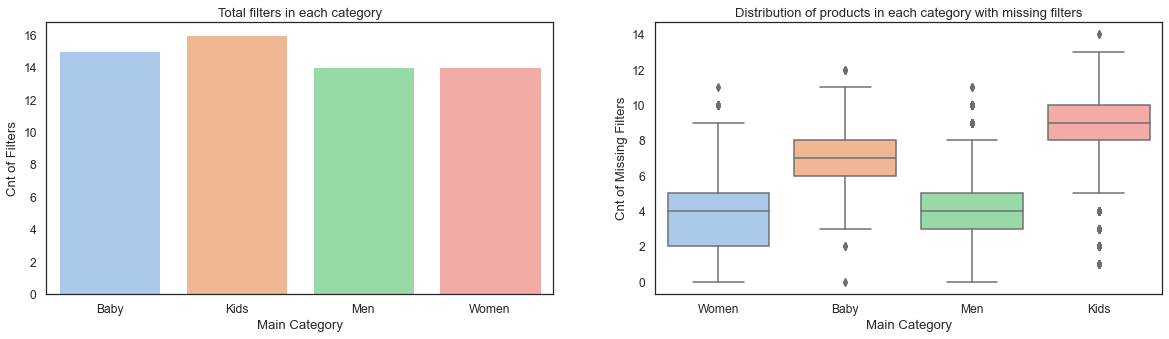

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(20,5))

sns.barplot(
    data=unique_filters.groupby('Top_Category')['Total_Filters'].max().reset_index(), 
    x='Top_Category', 
    y='Total_Filters',
    ax=axes[0]
)
axes[0].set(
    xlabel = 'Main Category',
    ylabel = 'Cnt of Filters',
    title = 'Total filters in each category'
)


sns.boxplot(data=unique_filters, x='Top_Category', y='Missing_Filters', ax=axes[1])
axes[1].set(
    xlabel = 'Main Category',
    ylabel = 'Cnt of Missing Filters',
    title = 'Distribution of products in each category with missing filters'
)

plt.show()

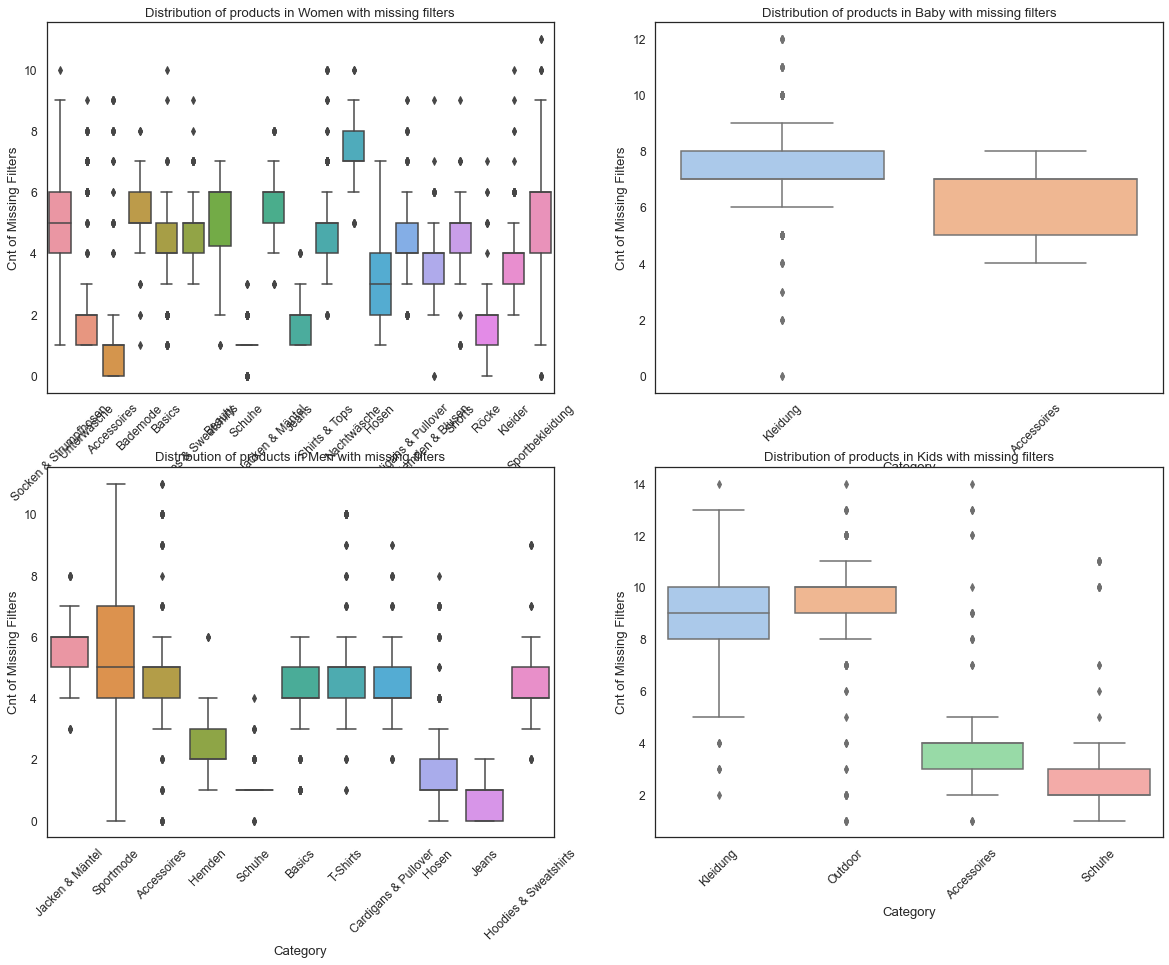

In [66]:
fig, axes = plt.subplots(2, 2, figsize=(20,15))
axes = axes.ravel()

for i, c in enumerate(unique_filters['Top_Category'].unique()):
    data = unique_filters[unique_filters['Top_Category'] == c]
    sns.boxplot(data=data, x='Parent_Category_Name', y='Missing_Filters', ax=axes[i])
    axes[i].set(
        xlabel = 'Category',
        ylabel = 'Cnt of Missing Filters',
        title = f'Distribution of products in {c} with missing filters'
    )
    axes[i].tick_params(axis='x', labelrotation = 45)

plt.show()

In [ ]:
unique_filters.sort_values(by='Missing_Filters', ascending=False)

In [ ]:
items[items['Code'] == '0981587001']

In [ ]:
items_attribs[items_attribs['Code'] == '0981587001']

In [ ]:
items_attribs[items_attribs['Code'] == '0981587001']

Looking at the image sizes once and measuring variance in the borders

In [45]:
dims = []
for idx, row in items_final.iterrows():
    dims.append(imread(hnm_img_file.format(row['Code'], row['Img_Ext'])).shape[:2])

In [46]:
items_final['Dim_Rows'] = list(zip(*dims))[0]
items_final['Dim_Cols'] = list(zip(*dims))[1]

del dims

C:\Users\Sahil\AppData\Local\Temp\ipykernel_2640\144995994.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_final['Dim_Rows'] = list(zip(*dims))[0]
C:\Users\Sahil\AppData\Local\Temp\ipykernel_2640\144995994.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_final['Dim_Cols'] = list(zip(*dims))[1]


In [47]:
items_final['Dim_Rows'].value_counts()

453    22216
333        3
Name: Dim_Rows, dtype: int64

In [48]:
items_final['Dim_Cols'].value_counts()

302    22216
222        3
Name: Dim_Cols, dtype: int64

Now, let's look at distribution of filters across different categories

Checking variance threshold of a few images

In [49]:
# read a few images
imgs = []
i = 0
for idx, row in items_final.iterrows():
    imgs.append(rgb2gray(imread(hnm_img_file.format(row['Code'], row['Img_Ext']))).reshape(-1))
    i += 1
    if i >= 512:
        break

In [50]:
imgs = np.array(imgs)

In [54]:
imgs[:512].shape

(512, 136806)

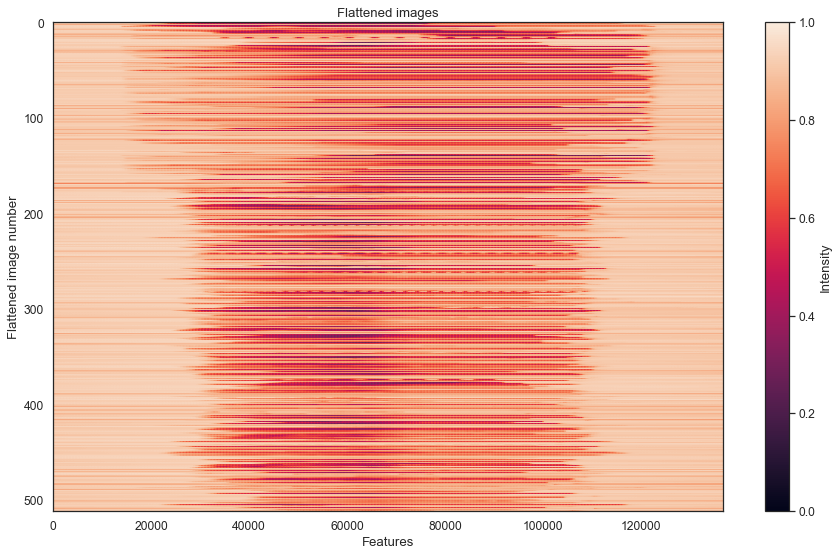

In [60]:
def plot_feature_sample(img, nrows=512):
    fig, ax = plt.subplots(figsize=(15,9))
    p = ax.imshow(img[:nrows], aspect='auto')
    plt.ylabel('Flattened image number')
    plt.xlabel('Features')
    plt.title('Flattened images')
    cb = plt.colorbar(p)
    _=cb.set_label('Intensity')
    
plot_feature_sample(imgs)

(512, 136806)
(512, 50987)


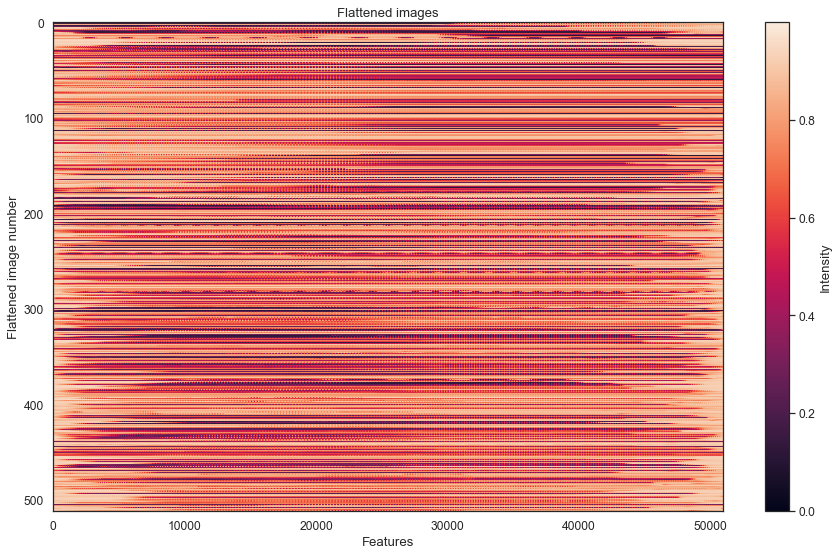

In [61]:
print(imgs.shape)
var_threshold = VarianceThreshold(0.05).fit(imgs)
imgs = var_threshold.transform(imgs)

plot_feature_sample(imgs)
print(imgs.shape)

In [ ]:
filters.head()

In [ ]:
f = filters.groupby('Parent_Category')['Filter_Name'].nunique()
plt.figure(figsize=(20, 10))
sns.barplot(x=f.index, y=f.values)
plt.show()

In [ ]:
cats.loc[[14, 232, 235, 242]]

In [ ]:
filters['Filter_Option_Name'] = filters.apply(lambda x: x['Filter_Option'][0], axis=1)
filters['Filter_Option_Value'] = filters.apply(lambda x: x['Filter_Option'][1], axis=1)

In [ ]:
f = filters.groupby('Parent_Category')['Filter_Option_Value'].nunique()
plt.figure(figsize=(20, 10))
sns.barplot(x=f.index, y=f.values)
plt.show()

In [ ]:
cats.loc[[232, 242, 343, 367]]

In [ ]:
# check which filter name has the largest number of options
filters.groupby('Filter_Name')['Filter_Option_Value'].nunique()

In [ ]:
filters[filters['Filter_Name'] == 'Produkttyp']

In [ ]:
filters[filters['Filter_Name'] == 'Style']

These seem quite similar to categories themselves

In [ ]:
# now let's check distribution of nr of filters per item
attributes.head()

In [ ]:
nr_attribs = attributes.groupby('Code')['Filter_ID'].count()

In [ ]:
items = items.merge(nr_attribs, how='left', left_on='Code', right_index=True).rename(columns={'Filter_ID': 'Nr_Filters'}).fillna(0)

In [ ]:
items.head()

In [ ]:
plt.figure(figsize=(20, 10))
sns.kdeplot(data=items, x='Nr_Filters', hue='Top_Category')
plt.show()

In [ ]:
# next, let's check for each top category for different filter names
attribs = attributes.merge(filters['Filter_Name'], how='left', left_on='Filter_ID', right_index=True)

In [ ]:
nr_attribs_2 = attribs.groupby(['Code', 'Filter_Name'])['Filter_ID'].count().reset_index().rename(columns={'Filter_ID': 'Nr_Filters_2'})

In [ ]:
nr_attribs_2.head()

In [ ]:
items_t = items.merge(nr_attribs_2, how='left', on='Code').fillna(0)

In [ ]:
items_g = items_t.groupby(['Top_Category', 'Parent_Category', 'Filter_Name'])['Code'].count().reset_index()

In [ ]:
items_g

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(data=items_g[items_g['Top_Category'] == 'Women'], y='Code', x='Filter_Name', hue='Parent_Category')
plt.show()